In [1]:
import pyspark
import re
import pyspark.sql
from pyspark.sql import *
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
import os.path
import json
from pyspark.sql.functions import desc
from datetime import timedelta, date

%matplotlib inline
#spark_hive = pyspark.sql.HiveContext(sc)

import findspark
findspark.init()

from pyspark.sql import dataframe
from pyspark.sql import functions as F
from pyspark.sql import DataFrameStatFunctions as statF
from pyspark.sql.functions import explode
from pyspark.sql.types import StructType
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [2]:
# import class XmlWiki
import os
import sys
my_class_dir = '../src/'
if my_class_dir not in sys.path:
    sys.path.append(my_class_dir)
    
import XmlWiki

# FRA 

In [3]:
DATA_DIR = '../wikidata/'

In [4]:
WIKIDATA    = os.path.join(DATA_DIR, 'wikidatawiki-20180801-pages-meta-history7.xml-p3488245p3490833')
SCHEMA_PATH = os.path.join(DATA_DIR, 'wikidatawiki-20180801-pages-meta-history7_schema.json')

In [9]:
%%time
# without any schema saved
wikidata = XmlWiki.XmlWikidump(path=WIKIDATA, path_schema=SCHEMA_PATH)

Saving schema in ../wikidata/wikidatawiki-20180801-pages-meta-history7_schema.json 

root
 |-- _corrupt_record: string (nullable = true)
 |-- id: long (nullable = true)
 |-- ns: long (nullable = true)
 |-- revision: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- comment: string (nullable = true)
 |    |    |-- contributor: struct (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- ip: string (nullable = true)
 |    |    |    |-- username: string (nullable = true)
 |    |    |-- format: string (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- model: string (nullable = true)
 |    |    |-- parentid: long (nullable = true)
 |    |    |-- sha1: string (nullable = true)
 |    |    |-- text: struct (nullable = true)
 |    |    |    |-- _VALUE: string (nullable = true)
 |    |    |    |-- _space: string (nullable = true)
 |    |    |-- timestamp: string (nullable = true)
 |-- title: string (nulla

save schema in order to load faster the data (spark does not need to infer the schema from data) so it will be faster in loading, [link](https://szczeles.github.io/Reading-JSON-CSV-and-XML-files-efficiently-in-Apache-Spark/) . 

In [5]:
%%time
# with the help of the schema
wikidata = XmlWiki.XmlWikidump(path=WIKIDATA, path_schema=SCHEMA_PATH, use_schema=True)

Loading the xml schema from ../wikidata/wikidatawiki-20180801-pages-meta-history7_schema.json


FileNotFoundError: [Errno 2] No such file or directory: '../wikidata/wikidatawiki-20180801-pages-meta-history7_schema.json'

- The element does not seem to be present in the data.

- The data contains (several, all?) revisions that have been done to the corresponding pages . The distribtuion is shown below.

- Revision.id is an array (probably the size of the array indicates the number of revisions)

In [47]:
# revision.id is an array
wikidata.dataframe.registerTempTable('test')

query_test = """
select size(revision.id)
from test
"""

result_query_test = spark.sql(query_test)
print(result_query_test.show())

+-------------------------+
|size(revision.id AS `id`)|
+-------------------------+
|                       25|
|                        4|
|                       27|
|                       62|
|                       12|
|                       13|
|                       27|
|                       18|
|                       12|
|                       28|
|                       12|
|                       22|
|                       24|
|                       13|
|                        7|
|                        1|
|                       14|
|                       12|
|                       12|
|                       16|
+-------------------------+
only showing top 20 rows

None


In [54]:
query_test = """
select size(revision.text._VALUE)
from test
"""

result_query_test = spark.sql(query_test)
print(result_query_test.show())

+--------------------------------------+
|size(revision.text._VALUE AS `_VALUE`)|
+--------------------------------------+
|                                    25|
|                                     4|
|                                    27|
|                                    62|
|                                    12|
|                                    13|
|                                    27|
|                                    18|
|                                    12|
|                                    28|
|                                    12|
|                                    22|
|                                    24|
|                                    13|
|                                     7|
|                                     1|
|                                    14|
|                                    12|
|                                    12|
|                                    16|
+--------------------------------------+
only showing top

In [37]:
print(type(wikidata.dataframe))

# filter to take only articles with revisions that are not null
articles_with_revisions = wikidata.dataframe\
    .filter("ns = '0'")\
    .filter("revision.text._VALUE is not null")

# create SQL view
articles_with_revisions.registerTempTable('wikidata_revised_articles')

<class 'pyspark.sql.dataframe.DataFrame'>


Try to count the number of revisions per page

In [52]:
# freq: nb of revisions in one page (ID)
query = """
SELECT t.id, size(t.revision.id) as freq
FROM wikidata_revised_articles as t
ORDER BY freq DESC
"""

result_query = spark.sql(query)
print(result_query.show())

+-------+----+
|     id|freq|
+-------+----+
|3489826| 153|
|3490785| 133|
|3488417| 121|
|3490577| 118|
|3488853| 116|
|3490020| 115|
|3489925| 108|
|3490249| 105|
|3490713| 102|
|3488525| 102|
|3490638| 102|
|3490452| 101|
|3488469|  94|
|3490500|  93|
|3489028|  91|
|3488581|  88|
|3488598|  86|
|3489985|  86|
|3490339|  85|
|3490361|  84|
+-------+----+
only showing top 20 rows

None


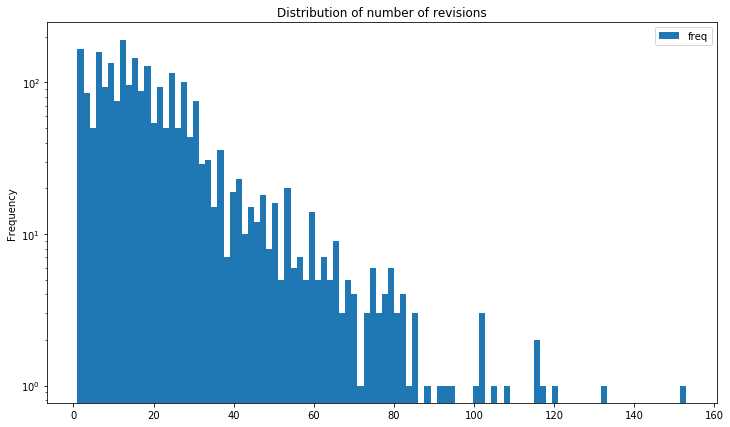

In [53]:
# histo plot
revisions = result_query.select('freq').toPandas()
revisions.plot(kind="hist", bins=100, log=True, figsize=(12,7), title="Distribution of number of revisions")
plt.show()

In [51]:
# freq: nb of pages that have conts nb of revisions
query_distribution = """
SELECT COUNT(*) AS counts, t1.freq
FROM (
    SELECT t.id, size(t.revision.id) as freq
    FROM wikidata_revised_articles as t   
    ) AS t1
GROUP BY t1.freq
ORDER BY counts DESC
"""

result_query_distributions = spark.sql(query_distribution )
print(result_query_distributions.show())

+------+----+
|counts|freq|
+------+----+
|   115|   1|
|   101|   6|
|    99|  13|
|    96|  14|
|    94|   8|
|    93|  12|
|    89|  15|
|    88|  17|
|    76|  11|
|    74|  10|
|    69|  18|
|    60|  19|
|    60|   9|
|    59|  25|
|    57|  16|
|    57|   7|
|    57|  24|
|    57|  27|
|    54|  20|
|    51|   2|
+------+----+
only showing top 20 rows

None


# Il tizio Tiziano 

# Get number of events by date

https://meta.wikimedia.org/wiki/Research:Characterizing_Wikipedia_Citation_Usage/First_Round_of_Analysis#Reference_click_data_collection

In [2]:
# required to iterate the range of dates
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [3]:
start_date = date(2018, 6, 29)
end_date = date(2018, 7, 9)

events_query = """
SELECT CONCAT(year, '-', month, '-', day) date, event.action, count(*) count
FROM event.citationusage
WHERE wiki = 'enwiki'
AND day = {}
AND month = {}
AND year = {}
AND useragent.is_bot = FALSE
GROUP BY year, month, day, event.action
ORDER BY year, month, day
"""

events_rdd = sc.emptyRDD()
for d in daterange(start_date, end_date):
    daily_events = spark.sql(events_query.format(d.day, d.month, d.year))
    events_rdd = events_rdd.union(daily_events.rdd)

events_merged = sqlContext.createDataFrame(events_rdd)
events = events_merged.toPandas()


In [6]:
events.pivot(index='date', columns='action', values='count')

action,extClick,fnClick,fnHover,upClick
date,,,,
2018-6-29,1380519,605630,910759,15827
2018-6-30,1175350,601558,719262,13258
2018-7-1,1292761,670059,781459,14333
2018-7-2,1506291,679810,1015227,17070
2018-7-3,1478117,658199,1008359,15638
2018-7-4,1396452,660584,939012,19189
2018-7-5,1473157,663406,1011750,21592
2018-7-6,1380359,643564,941362,15256
2018-7-7,1216492,641226,732253,13514


---

# Get number of references per page

https://meta.wikimedia.org/wiki/Research:Characterizing_Wikipedia_Citation_Usage/First_Round_of_Analysis#Dimensions_of_Analysis

In this case we use the public XML dump and we count the number of tag of type ```<ref>```

Example of reference:
```html
<ref>{{cite web| url=http://geonames.nga.mil/ggmagaz/geonames4.asp 
    |title=NGA GeoName Database |publisher=[[National Geospatial Intelligence Agency]] 
    |accessdate=2008-07-05 
    |archiveurl = https://web.archive.org/web/20080608190852/http://geonames.nga.mil/ggmagaz/geonames4.asp 
    <!-- Bot retrieved archive --> |archivedate = 2008-06-08}}</ref>
```


In [8]:
# WIKIPEDIA_XML_DUMP = 'enwiki-20180801-pages-articles-multistream.xml.bz2'
WIKIPEDIA_XML_DUMP = 'enwiki-20180801-pages-articles-multistream.xml.bz2'

wikipedia = sqlContext.read.format('com.databricks.spark.xml')\
   .options(rowTag='page').load(WIKIPEDIA_XML_DUMP)

ref_regex = re.compile(r'<ref[^>]*[^\/]>|<ref[ ]*>')

def get_refs_count(entity):
    text = entity.revision.text._VALUE
    refs = ref_regex.findall(text)
    return Row(id=entity.id, refs_count=len(refs))

articles = wikipedia.filter("ns = '0'").filter("redirect._title is null") \
    .filter("revision.text._VALUE is not null") \
    .filter("length(revision.text._VALUE) > 0")

references_count = sqlContext.createDataFrame(articles.rdd.map(get_refs_count))
references_count.show()

+---+----------+
| id|refs_count|
+---+----------+
| 12|       311|
| 25|       235|
| 39|        46|
|290|        20|
|303|       240|
|305|        83|
|307|       391|
|308|       150|
|309|        21|
|316|        29|
|324|       112|
|330|         6|
|332|        11|
|334|        12|
|336|        60|
|339|       214|
|340|         4|
|344|         7|
|358|       156|
|359|         7|
+---+----------+
only showing top 20 rows



In [9]:
non_zero = references_count.select("id").where("refs_count > 0").distinct().count()

print("Number of articles with #references > 0: " + str(non_zero))

Number of articles with #references > 0: 4310594


In [10]:
import pyspark.sql.functions as sf

refs_distribution = references_count\
                    .groupby('refs_count')\
                    .agg(sf.count('*').alias('total'))\
                    .toPandas()

refs_distribution.head()

,refs_count,total
0,26,12939
1,29,10210
2,474,5
3,65,1576
4,191,84


In [11]:
all_refs_count = references_count.select('refs_count').toPandas()

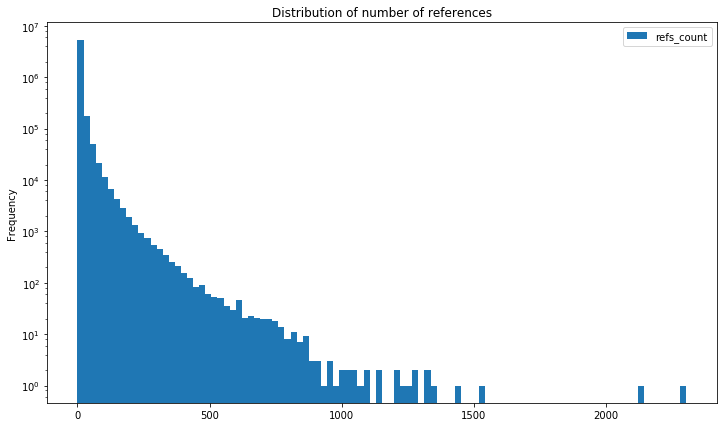

In [12]:
all_refs_count.plot(kind="hist", bins=100, log=True, figsize=(12,7), title="Distribution of number of references")

---

# Top domains in the references

In [14]:
WIKIPEDIA_XML_DUMP = 'enwiki-20180801-pages-articles-multistream.xml.bz2'

wikipedia = sqlContext.read.format('com.databricks.spark.xml')\
   .options(rowTag='page').load(WIKIPEDIA_XML_DUMP)

ref_regex = re.compile(r'(<ref[^>]*[^/]>|<ref[ ]*>){{([^<]*)}}</ref')

def get_refs_info(entity):
    text = entity.revision.text._VALUE
    text = re.sub("(<!--.*?-->)", "", text, flags=re.MULTILINE) # remove comments
    refs = ref_regex.findall(text)
    result = []
    for r in refs:
        ref_content = r[1].split(r"|")
        template = ref_content.pop(0).strip()
        properties = {}
        for p in ref_content:
            eq_index = p.find("=")
            p_name = p[0:eq_index].strip()
            p_value = p[eq_index+1:].strip()
            properties[p_name] = p_value
        result.append(Row(id=entity.id, 
                          template=template.lower(), 
                          template_original=template, 
                          url=properties.get("url", ""), 
                          title=properties.get("title")))
    return result


articles = wikipedia.filter("ns = '0'").filter("redirect._title is null") \
    .filter("revision.text._VALUE is not null") \
    .filter("length(revision.text._VALUE) > 0")

references_rrd = articles.rdd.flatMap(get_refs_info)

references = sqlContext.createDataFrame(references_rrd)

In [16]:
references.show()

+---+------------+-----------------+--------------------+--------------------+
| id|    template|template_original|               title|                 url|
+---+------------+-----------------+--------------------+--------------------+
| 12|    cite web|         cite web|      IAF principles|http://www.iaf-if...|
| 12|cite journal|     cite journal|The Dictionary of...|http://www.britan...|
| 12|   cite book|        cite book|The Individualist...|                    |
| 12|cite journal|     cite journal|Book Fair Unites ...|                    |
| 12|   cite book|        cite book|[[Demanding the I...|                    |
| 12|   cite book|        cite book|A Companion to Co...|                    |
| 12|   cite book|        cite book|The Anarchist Tra...|                    |
| 12| cite eb1911|      cite EB1911|                null|                    |
| 12|         lsj|              LSJ|                null|                    |
| 12|         lsj|              LSJ|                

In [17]:
from urllib.parse import urlparse

def get_domain(row):
    try:
        parsed_uri = urlparse(row['url'])
        return ('{uri.netloc}'.format(uri=parsed_uri), 1)
    except:
        return None
    
mapped_domains = references.where("length(url)>0").rdd.map(get_domain).filter(lambda row: row is not None)
domains_count = mapped_domains.reduceByKey(lambda a,b: a+b).filter(lambda r: len(r[0])>0).sortBy(lambda r: -r[1])
domains_count.take(30)

[('books.google.com', 639179),
 ('www.nytimes.com', 218270),
 ('www.bbc.co.uk', 185723),
 ('news.bbc.co.uk', 165430),
 ('www.theguardian.com', 147452),
 ('www.youtube.com', 113990),
 ('news.google.com', 113790),
 ('www.billboard.com', 110748),
 ('www.census.gov', 108408),
 ('www.allmusic.com', 80184),
 ('www.telegraph.co.uk', 69798),
 ('www.sports-reference.com', 68497),
 ('nla.gov.au', 64583),
 ('factfinder2.census.gov', 64231),
 ('www.washingtonpost.com', 62421),
 ('www.newspapers.com', 56812),
 ('archive.org', 53987),
 ('www.imdb.com', 53202),
 ('tvbythenumbers.zap2it.com', 52495),
 ('itunes.apple.com', 52056),
 ('www.stat.gov.pl', 51673),
 ('www.independent.co.uk', 50098),
 ('www.espncricinfo.com', 48202),
 ('www.baseball-reference.com', 47016),
 ('articles.latimes.com', 40668),
 ('timesofindia.indiatimes.com', 39589),
 ('cricketarchive.com', 38662),
 ('www.hollywoodreporter.com', 37531),
 ('variety.com', 36739),
 ('www.discogs.com', 36008)]

Total number of links:

In [18]:
from operator import add
domains_count.map(lambda r: r[1]).reduce(add)

18908198

In [19]:
def to_row(rdd):
    return Row(domain=rdd[0], count=rdd[1], perc=rdd[1]/18908198)

domains_distribution = sqlContext.createDataFrame(domains_count.map(to_row)).sort("count", ascending=False)
domains_distribution.show()

+------+--------------------+--------------------+
| count|              domain|                perc|
+------+--------------------+--------------------+
|639179|    books.google.com| 0.03380433185647834|
|218270|     www.nytimes.com|0.011543670105421998|
|185723|       www.bbc.co.uk|0.009822353245930681|
|165430|      news.bbc.co.uk|0.008749115066385491|
|147452| www.theguardian.com|0.007798310552914667|
|113990|     www.youtube.com|0.006028601985234129|
|113790|     news.google.com|0.006018024562679...|
|110748|   www.billboard.com|0.005857141965617242|
|108408|      www.census.gov|0.005733386121723498|
| 80184|    www.allmusic.com|0.004240700250758956|
| 69798| www.telegraph.co.uk|0.003691414697476724|
| 68497|www.sports-refere...|0.003622608563756...|
| 64583|          nla.gov.au|0.003415608404354...|
| 64231|factfinder2.censu...|0.003396992140657719|
| 62421|www.washingtonpos...| 0.00330126646653478|
| 56812|  www.newspapers.com|0.003004622650979221|
| 53987|         archive.org|0.

In [20]:
dd = domains_distribution.toPandas()

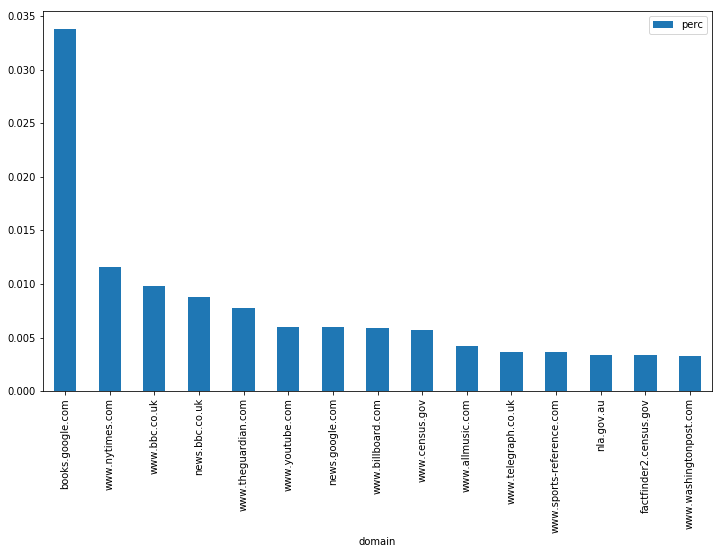

In [21]:
dd.head(15).plot(kind='bar',
                  x='domain',
                  y='perc',
                  figsize=(12,7))

---

# Get the pageviews by page

In this preliminary analysis, we use the table 'webrequest' to get the number of times a page is loaded and to evaluate the click rate. In the next data collection, we will have a 'page-load' event.

Get the pageviews by day (step 1) and aggregate (step 2).

In [25]:
# User must be NOT loggedIn, not a bot and the view must be in the English version of Wikipedia
# The views are aggregated by page, country, and access method

start_date = date(2018, 6, 29)
end_date = date(2018, 7, 9)

# step 1
links_query = """
select page_id, geocoded_data.continent, geocoded_data.country_code, access_method, count(*) as pageviews
from wmf.webrequest 
where day = {}
AND month = {}
AND year = {}
AND x_analytics_map['loggedIn'] is NULL
AND namespace_id = 0
AND agent_type = 'user'
AND is_pageview = TRUE
AND (uri_host = 'en.wikipedia.org' OR uri_host = 'en.m.wikipedia.org')
AND access_method <> 'mobile app'
group by page_id, geocoded_data.continent, geocoded_data.country_code, access_method
"""

pageviews = sc.emptyRDD()
for d in daterange(start_date, end_date):
    views_info = spark.sql(links_query.format(d.day, d.month, d.year))
    pageviews = pageviews.union(views_info.rdd)


# Convert the access_method string to be consistent with the events table
def convert_name(row):
    mode = 'desktop'
    if row['access_method'].startswith('mobile'):
        mode = 'mobile'
    return Row(page_id=row['page_id'], 
               continent=row['continent'], 
               country_code=row['country_code'], 
               access_method=mode,
               pageviews=row['pageviews']
              )


views_info_daily = sqlContext.createDataFrame(pageviews.map(convert_name).filter(lambda row: row is not None))
views_info_daily.registerTempTable("views_info_daily")

# step 2
aggregate_query = """
select page_id, continent, country_code, access_method, sum(pageviews) as pageviews
from views_info_daily
group by page_id, continent, country_code, access_method
"""

views_info = spark.sql(aggregate_query).cache()


# Count the number of visit with at least 1 extClick events


In [ ]:
start_date = date(2018, 6, 29)
end_date = date(2018, 7, 9)

# step 1
events_query = """
select event.page_id, geocoded_data.continent, geocoded_data.country_code, 
        event.mode, count(distinct(event.session_token)) total 
from event.citationusage
where wiki = 'enwiki'
AND day = {}
AND month = {}
AND year = {}
AND useragent.is_bot = FALSE
and event.in_infobox = FALSE
and event.footnote_number IS NOT NULL
and event.action = 'extClick'
group by event.page_id, geocoded_data.continent, geocoded_data.country_code, event.mode
"""

events_rdd = sc.emptyRDD()
for d in daterange(start_date, end_date):
    daily_events = spark.sql(events_query.format(d.day, d.month, d.year))
    events_rdd = events_rdd.union(daily_events.rdd)

events_merged = sqlContext.createDataFrame(events_rdd)
events_merged.registerTempTable("events_merged")

# step 2
aggregate_query = """
select page_id, continent, country_code, mode, sum(total) extClick_count
from events_merged
group by page_id, continent, country_code, mode
"""

clicks_count = spark.sql(aggregate_query)

# Get the click rate

Step 1: Filter out all the articles that do NOT contain any reference.

In [29]:
views_info.registerTempTable('views_info')
references_count.registerTempTable('references_count')

# join to filter out the pages without references
pages_with_refs_sql = """
select vi.*, rc.refs_count
from views_info vi
join references_count rc
on vi.page_id = rc.id
where rc.refs_count > 0
"""

pages_with_refs = spark.sql(pages_with_refs_sql)
pages_with_refs.cache().show()

+-------+-------------+------------+-------------+---------+----------+
|page_id|    continent|country_code|access_method|pageviews|refs_count|
+-------+-------------+------------+-------------+---------+----------+
|   1677|         Asia|          PK|      desktop|       10|        40|
|   1677|      Oceania|          AU|       mobile|      177|        40|
|   1677|         Asia|          SA|      desktop|       15|        40|
|   1677|         Asia|          AE|      desktop|        8|        40|
|   1677|       Europe|          --|       mobile|        4|        40|
|   1677|       Africa|          GH|       mobile|        2|        40|
|   1677|       Africa|          TN|       mobile|        2|        40|
|   1677|       Europe|          SI|       mobile|       14|        40|
|   1677|North America|          BM|       mobile|        1|        40|
|   1677|         Asia|          IN|       mobile|      195|        40|
|   1677|North America|          TT|       mobile|        4|    

Step 2: join with the external clicks count. Left join, set 0 clicks when there are no events.

In [31]:
clicks_count.registerTempTable('clicks_count')
pages_with_refs.registerTempTable('pages_with_refs')


pages_with_refs_sql = """
select pr.*,
    CASE WHEN ce.extClick_count is NULL THEN 0 ELSE extClick_count END AS extClick_count
from pages_with_refs pr
left join clicks_count ce
on pr.page_id = ce.page_id
and pr.continent = ce.continent
and pr.country_code = ce.country_code
and pr.access_method = ce.mode
"""

all_info = spark.sql(pages_with_refs_sql)

all_info.registerTempTable('all_info')
with_ratio_sql = """
select *, extClick_count / pageviews as clickrate
from all_info
"""

all_info = spark.sql(with_ratio_sql)
all_info.cache().show()

+-------+-------------+------------+-------------+---------+----------+--------------+---------+
|page_id|    continent|country_code|access_method|pageviews|refs_count|extClick_count|clickrate|
+-------+-------------+------------+-------------+---------+----------+--------------+---------+
|     25|       Europe|          CZ|   mobile web|        1|       235|             0|      0.0|
|     25|       Europe|          FR|      desktop|       18|       235|             0|      0.0|
|     39|       Europe|          PL|      desktop|        2|        46|             0|      0.0|
|    303|       Africa|          ZA|   mobile web|       16|       240|             0|      0.0|
|    305|         Asia|          IL|      desktop|        5|        83|             0|      0.0|
|    307|      Oceania|          NZ|      desktop|       18|       391|             0|      0.0|
|    308|       Europe|          BG|      desktop|        4|       150|             0|      0.0|
|    339|       Europe|       

Get pages with events:

In [35]:
all_info.where('extClick_count>0').count()

888103

### Get click rate by country 

In [36]:
all_info.registerTempTable('all_info')

avg_by_country = """
select country_code, access_method, avg(clickrate) clickrate_avg, count(*) count, sum(pageviews) total_views
from all_info
group by country_code, access_method
sort by clickrate_avg desc
"""

clickrate_by_country = spark.sql(avg_by_country)


In [37]:
cr = clickrate_by_country.toPandas()

Remove countries where there are less that 100 views in 1 week:

In [38]:
cr = cr[cr.total_views>100].sort_values(by='clickrate_avg', ascending=False)

** Top 15 **

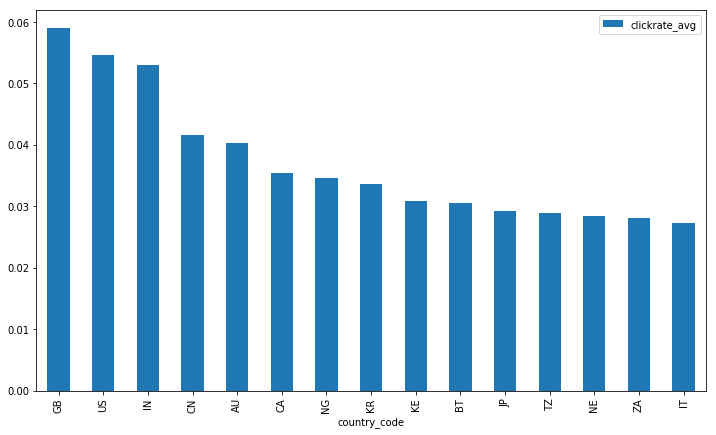

In [39]:
cr[cr.access_method=='desktop'].head(15).plot(kind='bar', 
                                              x='country_code', 
                                              y='clickrate_avg',
                                              figsize=(12,7))

** Last 15 **

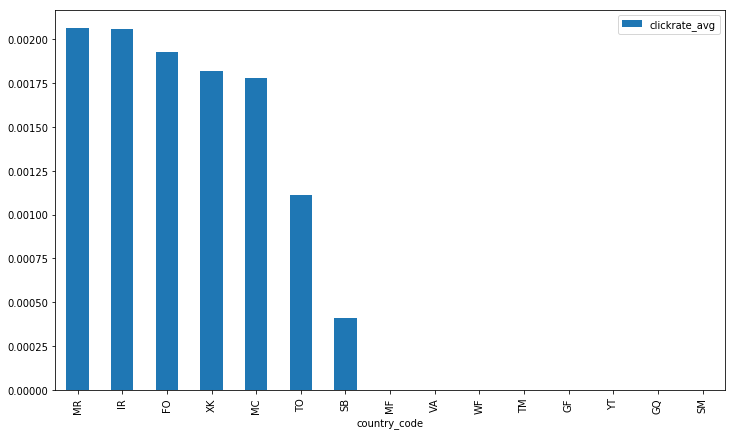

In [40]:
cr[cr.access_method=='desktop'].tail(15).plot(kind='bar', 
                                              x='country_code', 
                                              y='clickrate_avg',
                                              figsize=(12,7))

# Domains analysis - extClick events

In [41]:
from urllib.parse import urlparse

def get_domain(row):
    try:
        parsed_uri = urlparse(row['link_url'])
        return ('{uri.netloc}'.format(uri=parsed_uri), 1)
    except:
        return None

start_date = date(2018, 6, 29)
end_date = date(2018, 7, 9)

# step 1
events_query = """
select event.link_url, 1 as count
from event.citationusage
where wiki = 'enwiki'
AND day = {}
AND month = {}
AND year = {}
AND useragent.is_bot = FALSE
and event.in_infobox = FALSE
and event.footnote_number IS NOT NULL
and event.action = 'extClick'
"""

links_rdd = sc.emptyRDD()
for d in daterange(start_date, end_date):
    daily_events = spark.sql(events_query.format(d.day, d.month, d.year))
    links_rdd = links_rdd.union(daily_events.rdd)


links_rdd = links_rdd.map(get_domain)\
            .filter(lambda row: row is not None)\
            .reduceByKey(lambda a,b: a+b)\
            .filter(lambda r: len(r[0])>0).map(lambda r: Row(domain=r[0], count=r[1]))
    
links_merged = sqlContext.createDataFrame(links_rdd).sort("count", ascending=False)
links_merged.show()

+------+--------------------+
| count|              domain|
+------+--------------------+
|223368|     web.archive.org|
| 73554|    books.google.com|
| 56883|             doi.org|
| 56733|     www.nytimes.com|
| 47359| www.theguardian.com|
| 39602|       www.bbc.co.uk|
| 33731|     www.youtube.com|
| 32946|    www.allmusic.com|
| 32696|www.ncbi.nlm.nih.gov|
| 31617|  en.m.wikipedia.org|
| 26207| www.telegraph.co.uk|
| 23579|timesofindia.indi...|
| 23224|      tools.ietf.org|
| 22958|www.washingtonpos...|
| 22514|      news.bbc.co.uk|
| 20771|        www.imdb.com|
| 19164|www.independent.c...|
| 18930| www.dailymail.co.uk|
| 15001|      www.forbes.com|
| 14960|     news.google.com|
+------+--------------------+
only showing top 20 rows



In [42]:
click_urls = links_merged.toPandas()

** Top 15 **

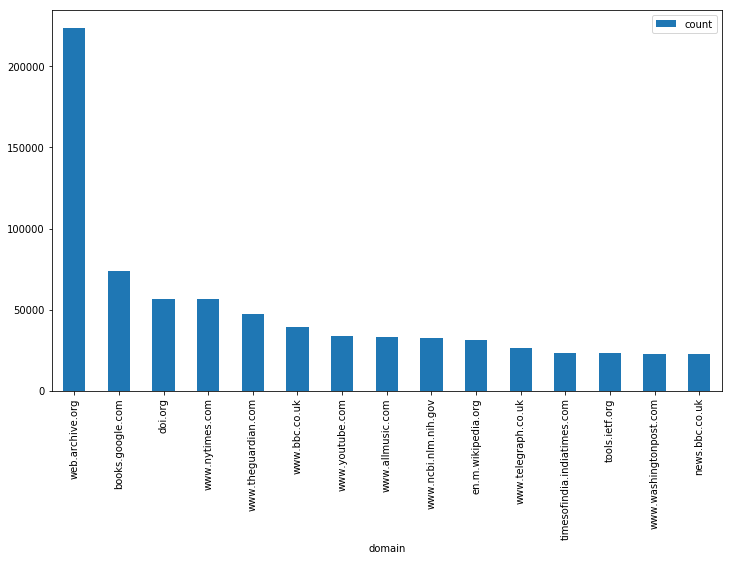

In [43]:
click_urls.head(15).plot(kind='bar', 
                  x='domain', 
                  y='count',
                  figsize=(12,7))